In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.gridspec as gridspec
import pandas as pd
%matplotlib inline
mpl.rcParams.update({'font.size': 16})

In [3]:
file_names = ['4x32.out', '6x32.out', '4x64_1-3.out', '4x64_4-7.out', '6x64.out', '4x128.out', '6x128.out']

data = []

# Read the file line by line
for file_name in file_names:
    loss_list = []
    
    file_path = '../data/HPsearch/losses/' + file_name
    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Loop through the lines to extract the loss data
        for line in lines:
            if "Epoch:" in line:
                parts = line.strip().split()
                epoch = parts[1]
            if "final loss:" in line:
                parts = line.strip().split()
                loss_values = [epoch]
                loss_values.extend([float(part) for part in parts[2:]])
                loss_list.append(loss_values)
                
    loss_list = np.array(loss_list)
    #print(loss_list.shape)
    loss_list = {'Epoch': loss_list[:,0], 'Total Loss': loss_list[:,1], 'BC Loss': loss_list[:,2], 'RTE Loss': loss_list[:,3]}
    data.append(pd.DataFrame(loss_list))


# Display the resulting DataFrame
data[0].head()

,Epoch,Total Loss,BC Loss,RTE Loss
0,0,0.5197,0.4919,-0.3884
1,0,0.4538,0.427,-0.4667
2,0,-0.096,-0.1221,-1.0292
3,0,-0.1297,-0.1943,-0.6881
4,0,-0.4157,-0.5516,-0.6854


In [4]:
types = ['int', 'float', 'float', 'float']
for df in data:
    for i,c in enumerate(df.columns):
        df[c] = df[c].astype(types[i])

In [5]:
# Delete canceled 4th run of 4x64_1-3 and append both 4x64 loss dataframes
data[2] = data[2].truncate(after=(data[2].Epoch == 99).cumsum().idxmax())
data[2] = pd.concat([data[2], data[3]], ignore_index=True)
data3 = data.pop(3)

0
1
2
3
4
5


(-4.5, -1.0)

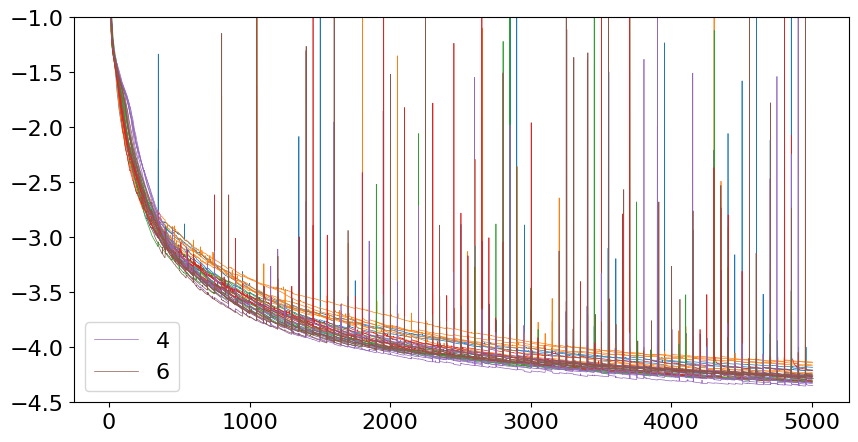

In [6]:
file_names = ['4x32', '6x32', '4x64', '6x64', '4x128', '6x128']

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

n_models = 7
d0 = 50

fig = plt.figure(figsize=(10,5))

for j, d in enumerate(data):
    print(j)
    zeros = (d.Epoch == 0).cumsum()
    ind_next = 0
    for i in range(n_models):
        ind_current = ind_next
        
        if i == n_models-1:
            losses = d['Total Loss'].iloc[ind_current:]
        else:
            ind_next = zeros.index[zeros==((i+1)*d0+1)].item()
            losses = d['Total Loss'].iloc[ind_current:ind_next]

        x = np.arange(losses.shape[0])
        
        if i == 0:
            plt.plot(x, losses, color=colors[j], label=file_names[j][:-4], linewidth=0.5)
        else:
            plt.plot(x, losses, color=colors[j], linewidth=0.5)
            
plt.legend()
#plt.xlim((2000,5050))
plt.ylim((-4.5, -1.0))

In [7]:
final_loss = np.zeros((len(data), n_models))

for j, d in enumerate(data):
    #print(j)
    zeros = (d.Epoch == 0).cumsum()
    ind_next = 0
    for i in range(n_models):

        if i == n_models-1:
            final_loss[j,i] = d['Total Loss'].iloc[-1]
        else:
            ind_next = zeros.index[zeros==((i+1)*d0+1)].item()
            final_loss[j,i] = d['Total Loss'].iloc[ind_next-1]
            
print(final_loss.shape)

(6, 7)


(-4.36, -4.12)

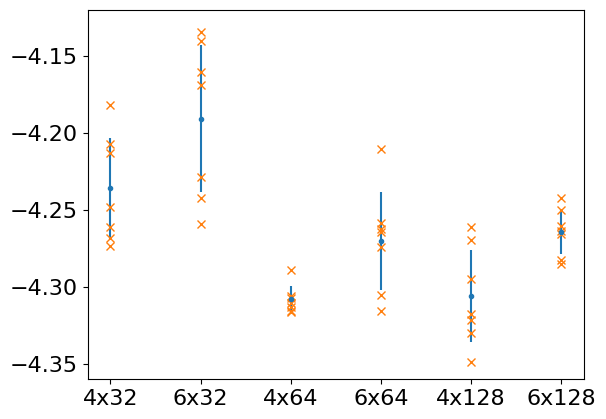

In [8]:
mean, std = final_loss.mean(axis=1), final_loss.std(axis=1)
plt.errorbar(file_names, mean, yerr=std, fmt='.')
plt.plot(file_names, final_loss, 'x', color=colors[1])
plt.ylim((-4.36, -4.12))

<ipython-input-9-5e9f1aaef0bd>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(file_names, rotation=45)


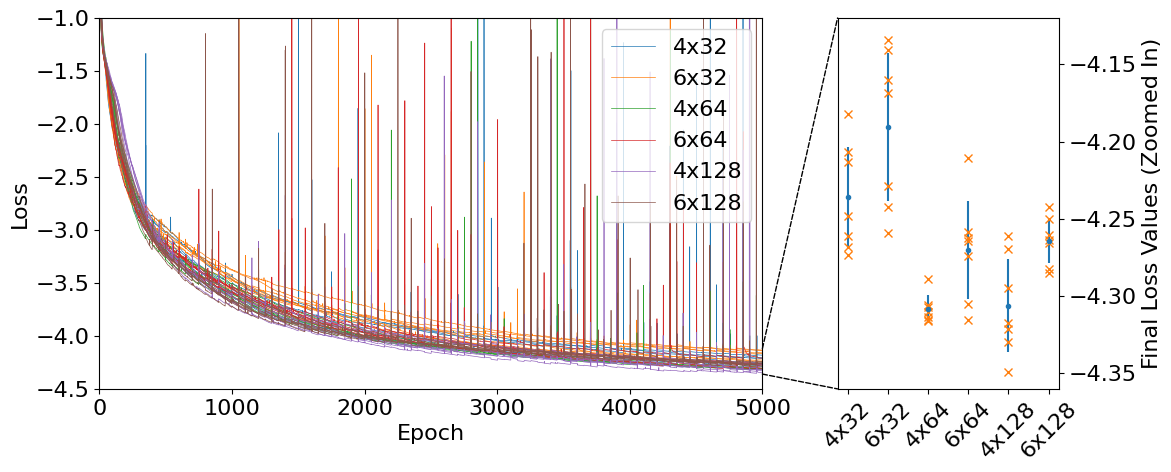

In [9]:
# Create a figure with a gridspec layout
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Two columns, with the second being half the width of the first

# Create the subplots using the gridspec layout
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Plot the loss function over epochs
for j, d in enumerate(data):
    #print(j)
    zeros = (d.Epoch == 0).cumsum()
    ind_next = 0
    for i in range(n_models):
        ind_current = ind_next
        
        if i == n_models-1:
            losses = d['Total Loss'].iloc[ind_current:]
        else:
            ind_next = zeros.index[zeros==((i+1)*d0+1)].item()
            losses = d['Total Loss'].iloc[ind_current:ind_next]

        x = np.arange(losses.shape[0])
        
        if i == 0:
            ax1.plot(x, losses, color=colors[j], label=file_names[j], linewidth=0.5)
        else:
            ax1.plot(x, losses, color=colors[j], linewidth=0.5)
            

# Set labels and limits for primary y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(-4.5, -1.0)  # Example range, adjust as needed
ax1.set_xlim(0, 5000)
ax1.legend(loc='upper right')

# Plot final loss values
mean, std = final_loss.mean(axis=1), final_loss.std(axis=1)
ax2.errorbar(file_names, mean, yerr=std, fmt='.')
ax2.plot(file_names, final_loss, 'x', color=colors[1])

# Set labels and limits for secondary y-axis
ax2.set_ylabel('Final Loss Values (Zoomed In)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xticklabels(file_names, rotation=45)

# This is the y-range for the right subplot
ymin, ymax = -4.36, -4.12

ax2.set_ylim(ymin, ymax)  # Zoomed-in range, adjust as needed

# We convert these to the normalized coordinate system of the left subplot
# by using the data limits of the left subplot
ymin_norm = (ymin - ax1.get_ylim()[0]) / (ax1.get_ylim()[1] - ax1.get_ylim()[0])
ymax_norm = (ymax - ax1.get_ylim()[0]) / (ax1.get_ylim()[1] - ax1.get_ylim()[0])

# Create connection lines between the plots
# From the right edge of the left plot to the left edge of the right plot
con1 = ConnectionPatch(xyA=(1, ymin_norm), xyB=(0, 0), coordsA='axes fraction', coordsB='axes fraction',
                       axesA=ax1, axesB=ax2, color="black", linestyle="--")
con2 = ConnectionPatch(xyA=(1, ymax_norm), xyB=(0, 1), coordsA='axes fraction', coordsB='axes fraction',
                       axesA=ax1, axesB=ax2, color="black", linestyle="--")

# Add the patches to the figure
ax1.add_artist(con1)
ax2.add_artist(con2)

# Adjust the space between the subplots if necessary
plt.subplots_adjust(wspace=0.05) 

plt.tight_layout()
#fig.savefig('../images/hp_search_loss.png', dpi=200)

plt.show()